In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

2024-02-12 11:26:42.650540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
# Define paths to your training and testing directories
train_dir = 'Datasets/RAF-DB/DATASET/train'
test_dir = 'Datasets/RAF-DB/DATASET/test'

# Set the image size for ResNet50V2
image_size = (224, 224)  # ResNet50V2 expects 224x224 input
batch_size = 64

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Use ResNet specific preprocessing
    rotation_range=15,   # reduced from 30
    width_shift_range=0.1,   # reduced from 0.2
    height_shift_range=0.1,  # reduced from 0.2
    shear_range=0.1,    # reduced from 0.2
    zoom_range=0.1, # reduced from 0.2
    horizontal_flip=True,
    fill_mode='constant'    # instead of 'nearest' because of blur
)

# Data generator for the test set (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load images from directories and resize them
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


train_generator and test_generator are now ready to be used in model training and evaluation

In [5]:
# Load the ResNet50V2 model without the top layer
base_model = ResNet50V2(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/ResNet50V2/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Add your existing code for predictions, classification report, and confusion matrix here

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [6]:
epochs = 15  # Increased number of epochs

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/15
191/191 [==============================] - 666s 3s/step - loss: 2.2427 - accuracy: 0.3421 - val_loss: 1.4452 - val_accuracy: 0.5100
Epoch 2/15
191/191 [==============================] - 698s 4s/step - loss: 1.8388 - accuracy: 0.4429 - val_loss: 1.2097 - val_accuracy: 0.5851
Epoch 3/15
191/191 [==============================] - 696s 4s/step - loss: 1.6972 - accuracy: 0.4706 - val_loss: 1.1817 - val_accuracy: 0.5991
Epoch 4/15
191/191 [==============================] - 691s 4s/step - loss: 1.5948 - accuracy: 0.4991 - val_loss: 1.1539 - val_accuracy: 0.6064
Epoch 5/15
191/191 [==============================] - 691s 4s/step - loss: 1.5230 - accuracy: 0.5071 - val_loss: 1.1108 - val_accuracy: 0.6150
Epoch 6/15
191/191 [==============================] - 679s 4s/step - loss: 1.4416 - accuracy: 0.5249 - val_loss: 1.1085 - val_accuracy: 0.6210
Epoch 7/15
191/191 [==============================] - 694s 4s/step - loss: 1.4187 - accuracy: 0.5324 - val_loss: 1.0643 - val_accuracy: 0.6290

48/48 [==============================] - 139s 3s/step - loss: 0.9846 - accuracy: 0.6490
Test accuracy:  0.6489569544792175
48/48 [==============================] - 138s 3s/step
Classification Report
              precision    recall  f1-score   support

           1       0.09      0.09      0.09       329
           2       0.00      0.00      0.00        74
           3       0.04      0.01      0.02       160
           4       0.38      0.44      0.41      1185
           5       0.16      0.15      0.16       478
           6       0.08      0.06      0.07       162
           7       0.24      0.25      0.25       680

    accuracy                           0.26      3068
   macro avg       0.14      0.14      0.14      3068
weighted avg       0.24      0.26      0.25      3068


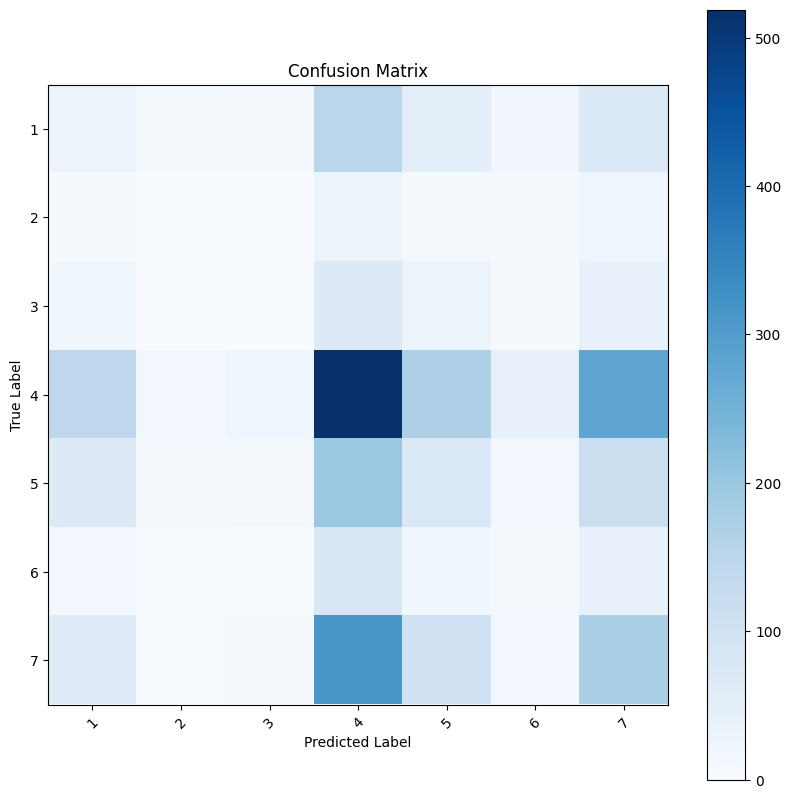

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
print("Test accuracy: ", test_accuracy)

# Predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# Since the generator omits some samples due to rounding down in 'steps', we trim 'true_classes' to match 'predicted_classes' length
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Conducting error analysis
This can be done by examining misclassified examples, which can provide insights into what types of errors the model is making